In [1]:
import ecalic
import cms_fstyle
import pandas as pd, numpy as np
import uproot
import awkward as ak
import os
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# filter out warnings 
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Define some variables used in different sections
ecal_path = Path(os.getenv('ECALPATH'))
ic_file = 'das_ic_smearing.txt'

# Ecal - Noise

The ecal noise is due leakage current of APDs (photo-detectors placed at the rear of the crystals). It is measured (in ADC count) and monitored during data-taking and stored in the database. It is dependent on the level of irradiation and its effect on physics is amplified by the loss of transparency in each crystal.
The translation of the noise from ADC counts to GeV is given by the following formul for any channel $i$.

$$N[GeV]_{i} = \frac{N[ADC]_i \times ADC2GeV_i \times IC_i}{R_i^{\alpha_i}}$$

with $ADC2GeV_i$ a constant factor transforming ADC into GeV (typically 1 ADC count $\approx~40$~MeV), $IC_i$ is the intercalibration constant, $R_i$ is laser-measured transparency (so the lower the transparency, the more amplified is the noise) and $\alpha_i$ a geometrical conversion factor transforming a transparency loss from laser-based to a physic-signal-based (because the propagation of light in the crystal is different depending on the signal type: scintillation vs direct laser injection).

In this part, we will extract the different components $N[ADC]$, $ADC2GEV$, $IC$, $R$ and $\alpha$ from the database (rather than using conddb we will use so prestored outputs) and extract the noise level in GeV, profile vs $\eta$. During this process, we will use some typical low level tools used in the DPG to play with channel-level information (based on the ecalic package)


In [4]:
path_to_xml = ecal_path / 'Conditions'
tags = dict(ic='EcalIntercalibConstants_TL180fb_v1_mc',
            adc='EcalADCToGeVConstant_2010_V2_Bon_mc',
            laser='EcalLaserAPDPNRatios_TL180fb_v1_mc',
            alpha='EcalLaserAlphas_EB_sic1_btcp1_EE_sic1_btcp1',
            noise='EcalPedestals_TL180fb_Model190fb_mc',
            status='EcalChannelStatus_UL_2018_v2_mc',
            )

def title_2d(tagname):
    # polishing the title when reading out a tag
    return Path(tagname).stem. \
        replace('EcalADCToGeVConstant_', 'ADC2GeV '). \
        replace('EcalLaserAPDPNRatios_', 'Laser R/R0 '). \
        replace('EcalLaserAlphas_', 'alpha '). \
        replace('EcalPedestals_', 'Noise '). \
        replace('EcalChannelStatus_', 'status '). \
        replace('EcalIntercalibConstants_', 'IC ')

## Get familiar with icCMS
Now that we have the tags (and corresponding xml file) we will transform the content of the xml into the class 'icCMS' which are based on pandas dataframe. This will allow to make easy plotting and computation of these tags.
- icCMS lines correspond to a single channel (== crystal)
- icCMS columns correspond to crystal property, (position, db ID, electronic, crytal type...). One of the property is named 'ic' and it corresponds to the value extracted from the tag

In [5]:
# transform the xml content into icCMS (pandas dataframe)
ic, adc2gev, laser, alpha, noise, status = [ecalic.xml(str(path_to_xml / tagname) + '.xml', type=tagtype).icCMS(title_2d(tagname)) 
                                        for tagtype, tagname in tags.items()]

In [6]:
# play with the noise table 
print(noise.columns)
noise

Index(['cmsswId', 'dbID', 'hashedId', 'ix', 'iy', 'iz', 'FED', 'ccu', 'strip',
       'Xtal', 'elecID', 'side', 'LME', 'ieta', 'eta', 'PNA', 'PNB', 'Module',
       'fabric', 'harness', 'dee', 'iphiTT', 'ietaTT', 'producer', 'ecal',
       'eic', 'ic'],
      dtype='object')


,cmsswId,dbID,hashedId,ix,iy,iz,FED,ccu,strip,Xtal,...,Module,fabric,harness,dee,iphiTT,ietaTT,producer,ecal,eic,ic
0,838904321,1011191681,0,-85,1,0,610,65,5,1,...,EB-1,1,9,24,71,-17,BCTP,0,0,2.529136
1,838904322,1011191682,1,-85,2,0,610,65,5,2,...,EB-1,1,9,24,71,-17,BCTP,0,0,2.529136
2,838904323,1011191683,2,-85,3,0,610,65,5,3,...,EB-1,1,9,24,71,-17,BCTP,0,0,2.529136
3,838904324,1011191684,3,-85,4,0,610,65,5,4,...,EB-1,1,9,24,71,-17,BCTP,0,0,2.529136
4,838904325,1011191685,4,-85,5,0,610,65,5,5,...,EB-1,1,9,24,71,-17,BCTP,0,0,2.529136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75843,872438884,2012056100,14643,56,100,1,648,5,5,1,...,EE+09,1,1,2,17,18,BCTP,1,0,1.986000
75844,872439012,2012057100,14644,57,100,1,648,5,3,1,...,EE+09,1,1,2,17,18,BCTP,1,0,2.060000
75845,872439140,2012058100,14645,58,100,1,648,5,3,2,...,EE+09,1,1,2,17,18,BCTP,1,0,2.009000
75846,872439268,2012059100,14646,59,100,1,648,5,2,1,...,EE+09,1,1,2,17,18,BCTP,1,0,1.921000


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


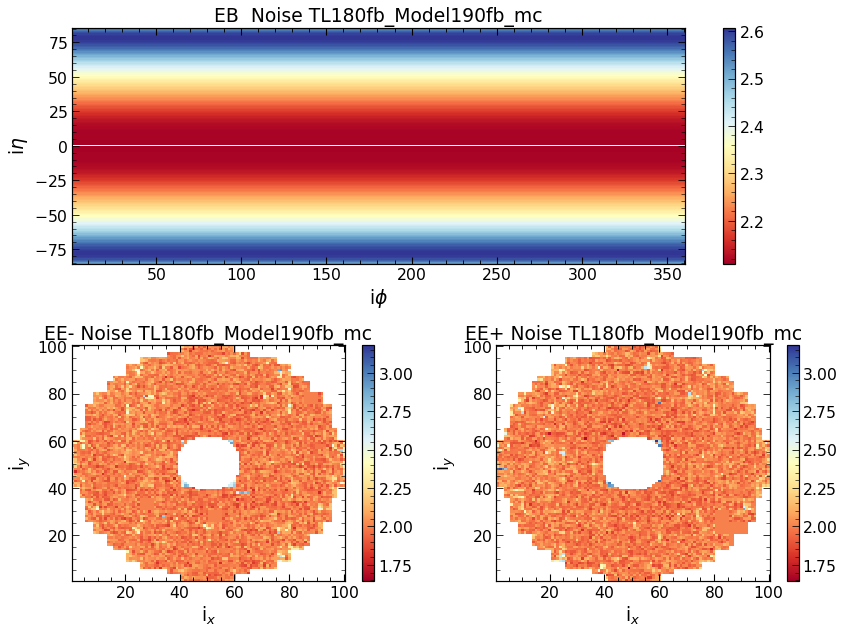

In [7]:
# plot the noise in 2D
noise.plot()

### some insight on Ecal crystal properties
Crystals are located based on their position $ix, iy, iz$, with: 
- EB $iz=0$ 
- EE- $iz=-1$
- EE+ $iz=+1$
Because in ecal mostly everything will depend on eta, crystals are arranged in eta-ring, the rings are numbered based on the number $i\eta$. Crystals belonging to the same $i\eta$ ring have approximately the same detector $\eta$ (based on detector geometry). In the icCMS, $\eta$ value for each crystal is also stored.
Now you can transform $i\eta$ to $\eta$ to exercise. 

EB eta range [-1.478,  1.478]


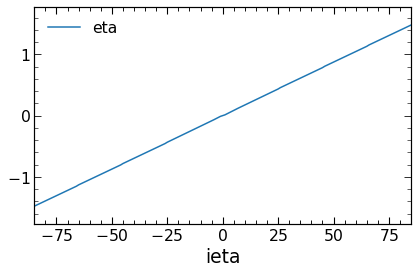

In [8]:
# use the plotting function of regular dataframe rather than the overloaded one from icCMS
# Full ECAL
# pd.DataFrame(noise).plot(x='ieta', y='eta')
# EB only
df_eb = noise.query('iz==0')
df_eb.plot(x='ieta', y='eta') 
print(f'EB eta range [{df_eb.eta.min(): .3f}, {df_eb.eta.max(): .3f}]')

In [9]:
# find the eta and ieta range of the different parts of ecal: EB, EE+, EE-

## Noise in ADC
You can use built in functions to project and average on $\eta$ or $i\eta$ to get eta-dependent plot of the tag content

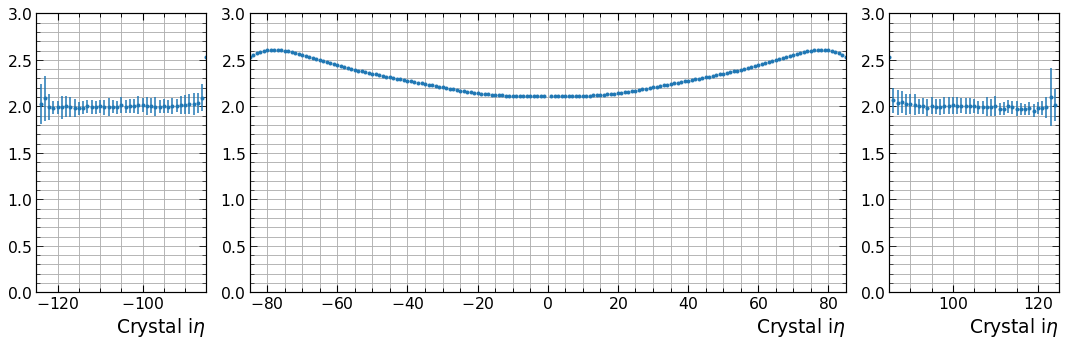

In [10]:
# plot the noise vs eta
# note the eta dependence of the noise ?
axes = noise.plotEtaEBEE() #returns 3 axes: EB, EE+, EE-
for ax in axes:
    cms_fstyle.polish_axis(ax, y_range=(0, 3))

## Converting the noise from ADC to GeV
In this part we will eventually compute the noise level in GeV as it was at the beginning of Run3
1. First, you will see how to compute solely the correction $R^\alpha$ using icCMS
2. Then, you will compute the total noise level based on the formula

$$N[GeV]_{i} = \frac{N[ADC]_i \times ADC2GeV_i \times IC_i}{R_i^{\alpha_i}}$$

3. Plot the noise profile in 1D in GeV, Plot the transverse noise in GeV as well
4. Save to a ecal-type txt file ready to be incorporated in the DB for MC simulation


In [11]:
# 1. we compute the laser correction R^alpha as example
lc = ecalic.icCMS(noise.copy())
lc['ic'] = laser['ic'] ** alpha['ic']
lc.dump('laser_correction.run3.txt') # dump to a regular ecal typical txt file

Dumping iov file to: laser_correction.run3.txt


In [12]:
# you can see the content of the output with cat or less 
# less laser_correction.run3.txt

In [13]:
# 2. [YOUR TURN] compute the noise in GeV based on the previous formula 
noise_gev = ecalic.icCMS(noise.copy())
# ...

In [14]:
# 2. [A SOLUTION] compute the noise in GeV based on the previous formula
noise_gev = ecalic.icCMS(noise.copy())
noise_gev['ic'] = noise['ic'] * ic['ic'] * adc2gev['ic'] / (laser['ic']**alpha['ic'])

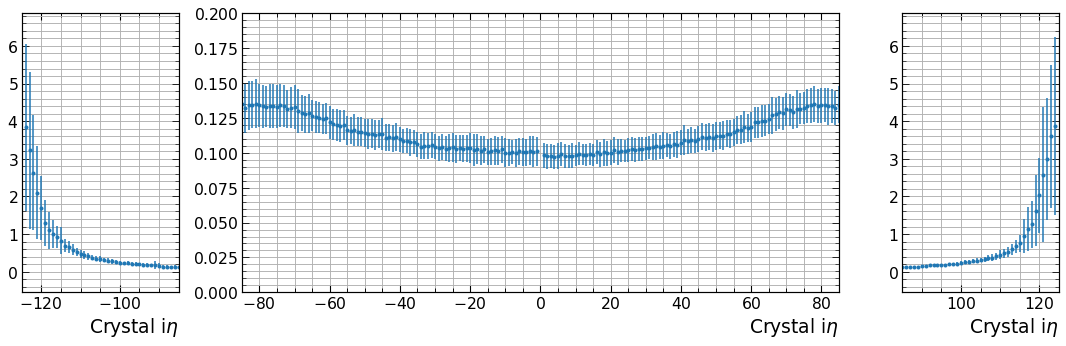

In [15]:
# 3.a plot the noise profile in GeV
axes = noise_gev.plotEtaEBEE()
cms_fstyle.polish_axis(axes[0], y_range=(0, .2))

In [16]:
# 3.b [YOUR TURN] plot the transverse noise profile in GeV (N_T = N / cosh(eta))
# add a column N_t that you can plot using the functino plotEtaEBEE
noise_gev['ic_t'] = np.nan  # ...

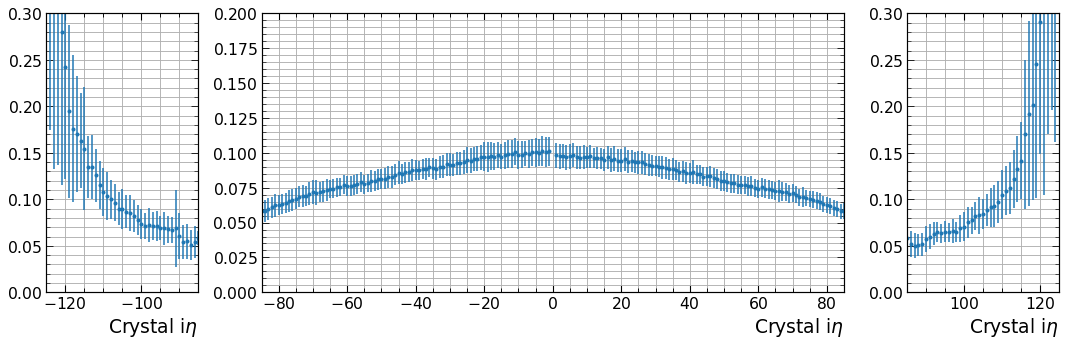

In [17]:
# 3.b [A SOLUTION] plot the transverse noise profile in GeV (N_T = N / cosh(eta))
# add a column N_t that you can plot using the functino plotEtaEBEE
noise_gev['ic_t'] = noise_gev.eval('ic/cosh(eta)')
axes = noise_gev.plotEtaEBEE(yvar='ic_t')
cms_fstyle.polish_axis(axes[0], y_range=(0, .2))
for ax in axes[1:]: cms_fstyle.polish_axis(ax, y_range=(0, .3))

In [18]:
# 4. [YOUR TURN] dump the content of the noise_gev  

# Changing the Ecal IC
Using icCMS, we will now change the ecal eta scale as well as the precision of the intercalibration constants. Then we will see what is the effect on the $Z$ boson and try to measure the scale using the $Z\to e e$ decay. 

### $\eta$ scale tuning
Change the eta scale per ieta ring using the following formula. For this create a new icCMS object, add an `ic` column and setup this `ic` column to be
$$IC_1 = 1 + 0.02 \times \sin(i\eta \times \pi/25)$$

### Ecal response smearing
Smear the `ic` to increase the ecal resolution with the $\eta$ dependent smearing below
$$IC_2 = IC_1 \times \mathcal(1, \sigma_{E}(\eta))$$

with:
- EB:   $\sigma_{E}(\eta) = 0.01\times( 1 + 0.005* \times |\eta|^2$)
- EE:   $\sigma_{E}(\eta) = 0.03$
For this you may use the numpy random number generator using the seed 1234 



In [19]:
# 1. [YOUR TURN] create a ic_recalib iCMS object and prepare the average scale and smearing 
# TIP: you the ic_recalib.loc[..] function to set different values for EB and EE
ic_recalib = ecalic.icCMS()
ic_recalib['ic'] = np.nan  # prepare an ic
ic_recalib['eic'] = 0
ic_recalib['rE'] = np.nan  # store the scale shift (according to IC1 formula) 
ic_recalib['sE'] = np.nan  # store the resolution to do the smearing (according to IC2 formula)
# ...

In [20]:
# 1. [A SOLUTION] create a ic_recalib iCMS object and prepare the average scale and smearing 
ic_recalib = ecalic.icCMS()
ic_recalib['ic'] = np.nan  # prepare an ic
ic_recalib['eic'] = 0
ic_recalib['rE'] = np.nan  # store the scale shift (according to IC1 formula) 
ic_recalib['sE'] = np.nan  # store the resolution to do the smearing (according to IC2 formula)

ic_recalib['rE'] = 1 + 0.02*np.sin(ic_recalib.ieta * np.pi / 25)
ic_recalib.loc[ic_recalib.iz==0, 'sE'] = 0.01 * (1+ ic_recalib[ic_recalib.iz==0].eta.abs()**2)
ic_recalib.loc[ic_recalib.iz!=0, 'sE'] = 0.03

In [21]:
# 2. [YOUR TURN] smear the IC according the the formula using the random number generator from numpy
rng = np.random.default_rng(1234)
ic_recalib['ic'] = np.nan

In [22]:
# 2. [A SOLUTION] smear the IC according the the formula using the random number generator from numpy
rng = np.random.default_rng(1234)
ic_recalib['ic'] = ic_recalib['rE'] * rng.normal(1, ic_recalib['sE'])

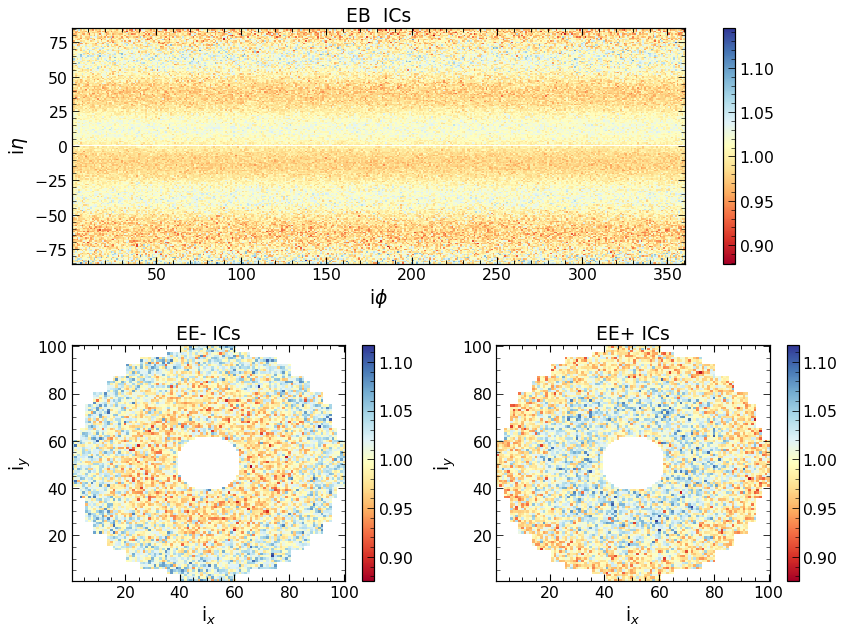

In [23]:
ic_recalib.plot()

In [24]:
# 3. dump the new IC file
ic_recalib.dump(ic_file)

Dumping iov file to: das_ic_smearing.txt


In [25]:
# 4. [YOUR TURN] plot the scale to check this was implemented properly


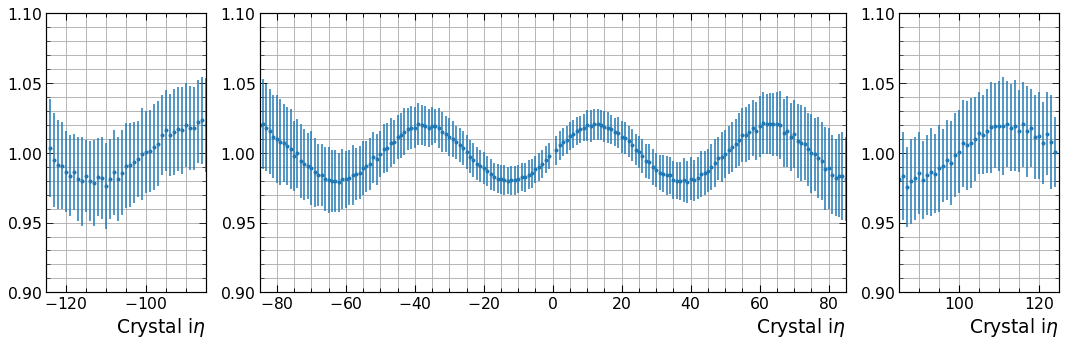

In [26]:
# 4. [A SOLUTION using icCMS built in functino] plot the scale to check this was implemented properly
axes = ic_recalib.plotEtaEBEE()
for ax in axes:
    cms_fstyle.polish_axis(ax, y_range=(0.9, 1.1))

In [27]:
# 5. [YOUR TURN] plot the smearing vs ieta: the smearing is given by the standard deviation of IC
# NB you can try to do it with regular pandas tool, in this case you can use the dataframe function .groupby()

<AxesSubplot:xlabel='ieta'>

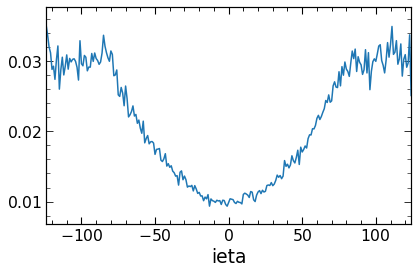

In [28]:
# 5. [A SOLUTION using pandas tool] plot the smearing vs ieta: the smearing is given by the standard deviation of IC
ic_recalib.groupby('ieta').ic.std().plot()

# Ecal - $\eta$ scale and the IJazZ tool
IJazZ is a tool to analyize the $Z\to ee$ decay events in view of calibrating ECAL. 
The main purposes are two fold:
- compute the intercalibration constants and especially the $\eta$-scale which is the response of Ecal vs eta. This measurement is done using a MC as reference
- measure and monitor the Ecal resolution
In this part, we will first compute the eta-scale and the resolution for the MC out-of-the-box.
Then we will smear the MC with the smearing txt file which was setup in the previous section
Eventually we will compare the scale and the resolution of the smeared MC to the corresponding measurements from the raw MC and see how it compare with the theoretical smearing we used

### re-calibration of the dataset
Each SuperCluster (SC) is a set of crystals energies (rechits). Its raw energy is the sum of the rechit energies multiplied by a fraction (per rechit) which is obtained during the clustering process (to share the energy of crysals among overlapping clusters). Therefore the raw energy of a SC is given by

$$E_{SC}^{raw} = \sum_{rh} E_{rh} \times f_{rh} \times IC_{rh}$$

where $IC_{rh}$ is a calibration factor ($IC_{rh} = 1$ for default reconstruction). In addition an energy regression is added on top of the raw energy to calibrate the energy loss due to leakage. Thus the recalibrated energy: 

$$E_{SC}^{recalib} = E_{SC} \times \frac{E_{SC}^{raw, \, IC\equiv IC_{recalib}}}{E_{SC}^{raw, \, IC\equiv 1}}$$


In [29]:
# input tree 
froot = ecal_path / 'data/DYEE_madgraph_UL2018.root'

In [30]:
# get the trees 
file = uproot.open(froot)
# 1. main tree    
main_tree = uproot.open(froot)['selected']
# 2. tree containing the per rechit information
rh_tree = uproot.open(froot.with_stem('extraCalibTree-' + froot.stem))['extraCalibTree']

In [31]:
# check the content of the main tree and of the xtal_info tree
# rh_tree.show()

In [32]:
# readout the calibration to be applied to calibrate the SC energies
# IMPORTANT NOTE we re-index as a function of cmsswId to easily get the per-crystal correction
resp_corr_ic = ecalic.icCMS(ic_file, error=False).set_index('cmsswId')['ic']

In [33]:
# first extract the xtal level information per cluster
xtal_info = rh_tree.arrays(filter_name=['energyRecHit*', 'fracRecHit*', 'rawIdRecHitSC*'])

In [34]:
# here you can play a bit with xtal_info to understand its structure
xtal_info.fields

['rawIdRecHitSCEle1',
 'rawIdRecHitSCEle2',
 'energyRecHitSCEle1',
 'energyRecHitSCEle2',
 'fracRecHitSCEle1',
 'fracRecHitSCEle2']

In [35]:
# 1. [YOUR TURN] for each electron compute the calibration correction factor 
# TIP: 
#  a. flatten the array of rechit for each electron and locate the corresponding IC correction in the object resp_corr_ic
#  b. re-shape the flatten awkward array to its original shape using the function ak.unflattenv and ak.num
corr_en = {}
for ele in ['Ele1', 'Ele2']:
    erh = xtal_info['energyRecHitSC' + ele] 
    frh = xtal_info['fracRecHitSC' + ele]
    irh = xtal_info['rawIdRecHitSC' + ele]
    # ... 

In [36]:
# 1. [A SOLUTION] for each electron compute the calibration correction factor 
corr_en = {}
for ele in ['Ele1', 'Ele2']:
    erh = xtal_info['energyRecHitSC' + ele] 
    frh = xtal_info['fracRecHitSC' + ele]
    irh = xtal_info['rawIdRecHitSC' + ele]
    ic_corr = resp_corr_ic.loc[ak.flatten(irh)]  # get the calibration correction from the flatten array
    ic_corr = ak.unflatten(ic_corr, ak.num(irh)) # reshape based on the orginal awkward shape
    corr_en[ele] = ak.sum(ic_corr*erh*frh, axis=1) / ak.sum(erh*frh, axis=1)

In [37]:
# 2. compute the calibrated energy per SC and add it to the original tree
data = main_tree.arrays()
data['mustCalibEnergySCEle'] = ak.Array(np.array([data.mustEnergySCEle[:, 0] * corr_en['Ele1'], 
                                                  data.mustEnergySCEle[:, 1] * corr_en['Ele2'], 
                                                  data.mustEnergySCEle[:, 2]], dtype=np.float32).T)

In [38]:
# 3. [YOUR TURN] 
# 3.a plot the Zee invariant for the original energy mustEnergySCEle 
# 3.b plot the Zee invariant for the recalibrated energy mustCalibEnergySCEle 

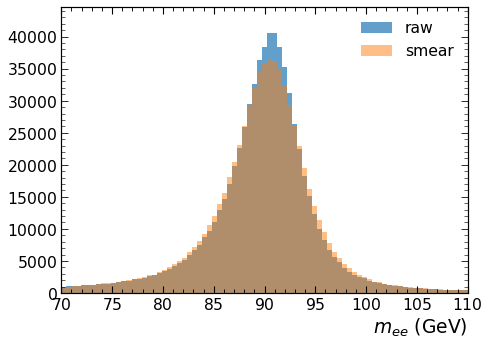

In [39]:
# 3. [A SOLUTION] 

fig, ax = plt.subplots(figsize=(7,5))
# 3.a plot the Zee invariant for the original energy mustEnergySCEle 
deta = data['etaEle'][:, 0] - data['etaEle'][:, 1]
dphi = data['phiEle'][:, 0] - data['phiEle'][:, 1]
pt1pt2 = data['mustEnergySCEle'][:, 0] / np.cosh(data['etaEle'][:, 0]) * \
         data['mustEnergySCEle'][:, 1] / np.cosh(data['etaEle'][:, 1])
m12 = np.sqrt(2* pt1pt2 * (np.cosh(deta) - np.cos(dphi)))

# 3.b plot the Zee invariant for the recalibrated energy mustCalibEnergySCEle 
pt1pt2 = data['mustCalibEnergySCEle'][:, 0] / np.cosh(data['etaEle'][:, 0]) * \
         data['mustCalibEnergySCEle'][:, 1] / np.cosh(data['etaEle'][:, 1])
m12_calib = np.sqrt(2* pt1pt2 * (np.cosh(deta) - np.cos(dphi)))

ax.hist(m12, bins=np.linspace(70, 110, 82), alpha=0.7, label='raw')
ax.hist(m12_calib, bins=np.linspace(70, 110, 82), alpha=0.5, label='smear')
cms_fstyle.polish_axis(x_title='$m_{ee}$ (GeV)')
plt.legend()

In [40]:
# 4. finally save the root file including the new calibrating energy
with uproot.recreate('das_tree.root') as froot:
    froot['selected'] = data

### Measure the scale and resolution in data
Now we use IJazZ to compute the response per xtal as well as the resolution vs eta.
This will be measured for both the original and re-calibrated energies so it can be compared to the original calibration file (including a scale shift and energy smearing).

Next, we will measure the eta scale and the resolution in the shell with the commands
- original MC: `IJazZ.py -c etascale.cfg --hdf mc_raw.hdf5`
- recalibd MC: `IJazZ.py -c etascale.cfg --hdf mc_smear.hdf5 --energy mustCalibEnergySCEle`

In [41]:
import ijazz

# quick and dirty trick for IJazZPlotter options when not running in shell
class DictToOpt:
    def __init__(self, kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

In [42]:
# define a config file giving the different fit outputs as well as the
cfg = {'mc_raw' : {'path': 'IJazZ_output/etascale_resp/ecalelf_das/000000-999999/mc_raw.hdf5',
                   'name':  'raw MC' },
      'mc_smear' : {'path': 'IJazZ_output/etascale_resp/ecalelf_das/000000-999999/mc_smear.hdf5',
                    'name': 'recalibrated MC'},
       "ref": {'path': 'IJazZ_output/etascale_resp/ecalelf_das/000000-999999/mc_raw.hdf5'}
      }

In [43]:
#1. [YOUR TURN]
# 1.a Get a pandas.Series of the average IC vs ieta
# 1.b Get a pandas.Series of the over-smearing == standard deviation of the IC
resp_corr_ic = ecalic.icCMS(ic_file, error=False)
scale = pd.Series()
reso = pd.Series()
scale.name = 'ic scale'
reso.name = 'ic resolution'

In [44]:
#1. [A SOLUTION]
resp_corr_ic = ecalic.icCMS(ic_file, error=False)
# 1.a Get a pandas.Series of the average IC vs ieta
scale = resp_corr_ic.groupby('ieta').ic.mean()
# 1.b Get a pandas.Series of the over-smearing == standard deviation of the IC
reso  = resp_corr_ic.groupby('eta').ic.std()
scale.name = 'ic scale'
reso.name = 'ic resolution'

 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 - saving plots/response.resp.abs.r9_HighBrem.jpg
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF part to SingleAxis
 * Adding EEpVF part to SingleAxis
 - saving plots/response.resp.abs.r9_LowBrem.jpg
 * Adding EEm part to SingleAxis
 * Adding EEp part to SingleAxis
 * Adding EEmVF par

<AxesSubplot:title={'left':'CMS $Preliminary$'}, xlabel='ieta', ylabel='$r_i(\\eta) / r_{ref}(\\eta)$'>

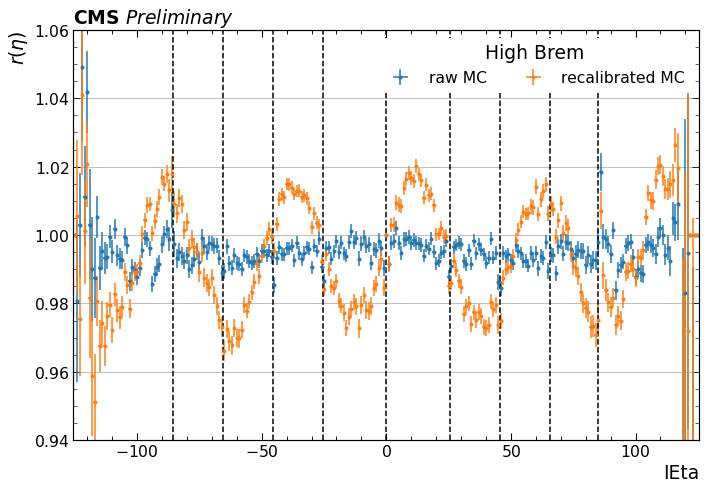

<Figure size 720x504 with 0 Axes>

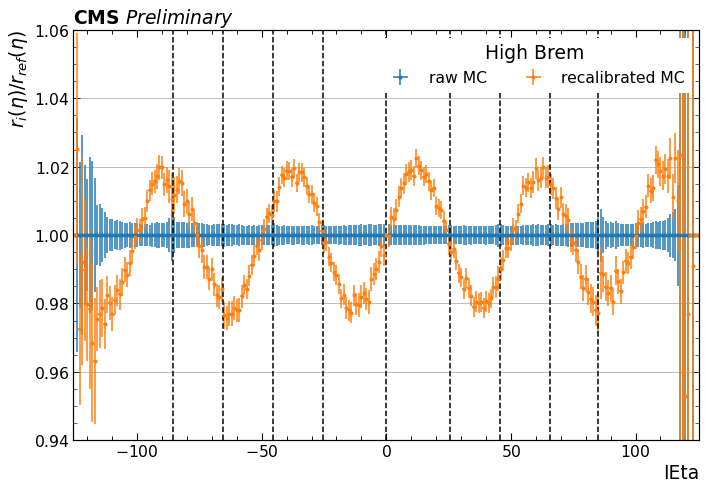

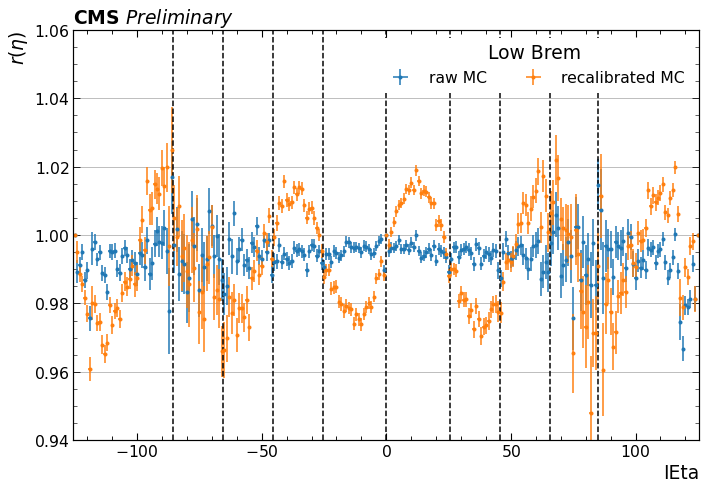

<Figure size 720x504 with 0 Axes>

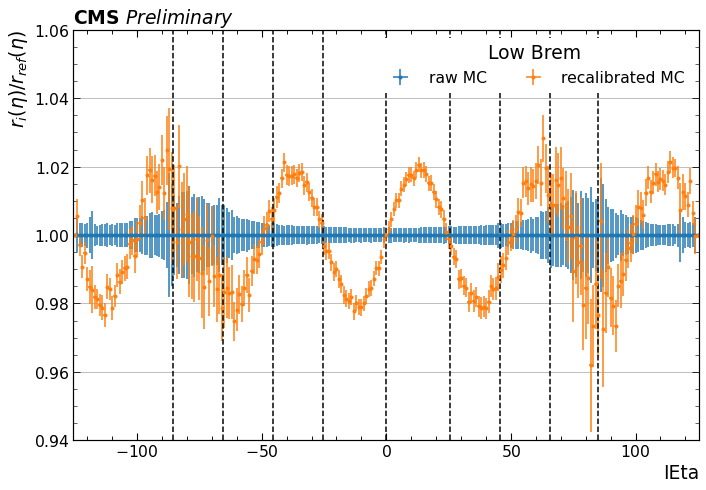

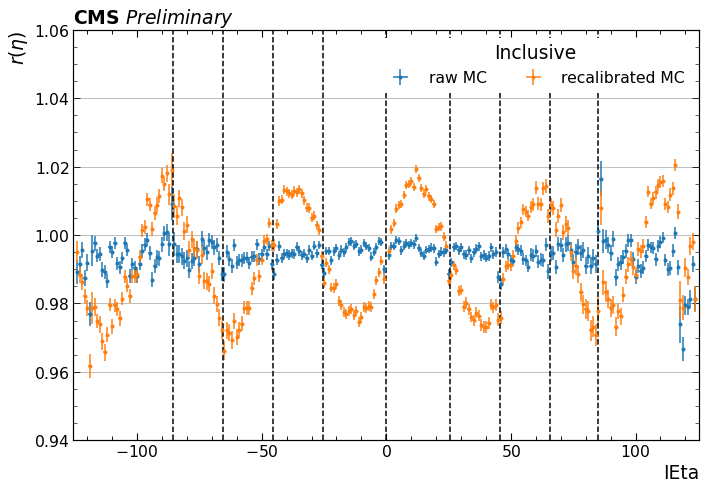

<Figure size 720x504 with 0 Axes>

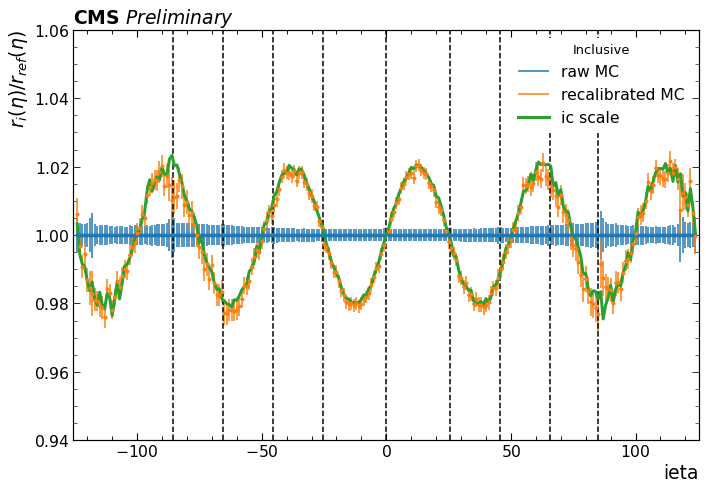

In [45]:
# 2. checkout the measured responses
ijazz.IJazZEtaPlotter.eta_comparison(cfg, 
            args=DictToOpt(dict(r_name='resp', out='plots/response.jpg', x_range=None, y_range=(0.94, 1.06))))

# the last axis contains the inclusive ratio, compare it to the original scale shift
scale.plot(ax=plt.gca(), legend='original scale', lw=3)


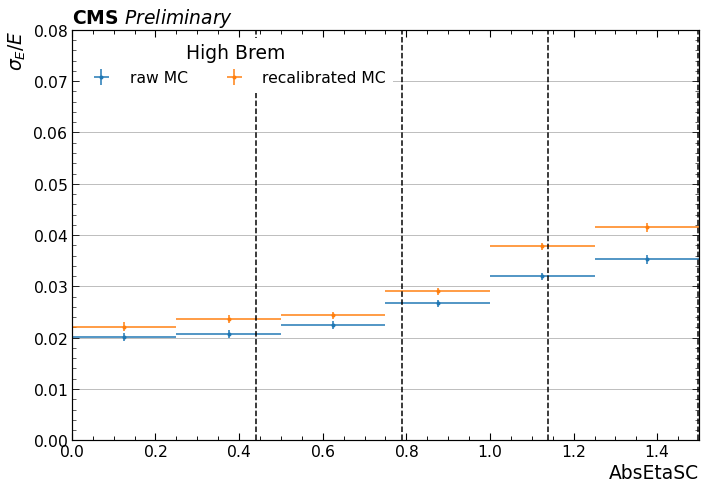

<Figure size 720x504 with 0 Axes>

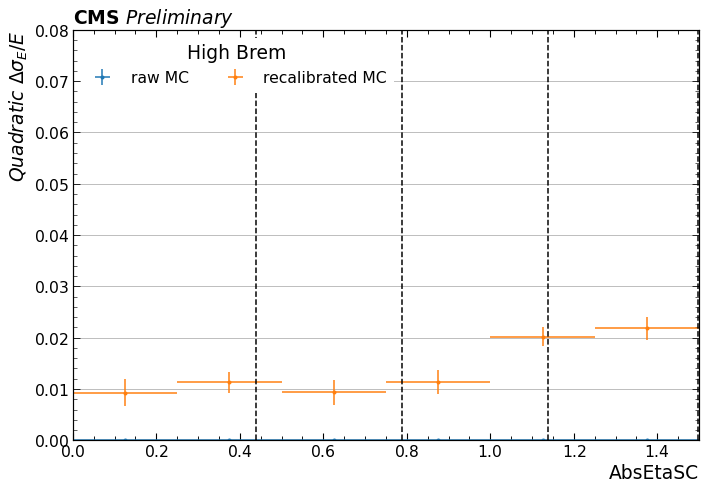

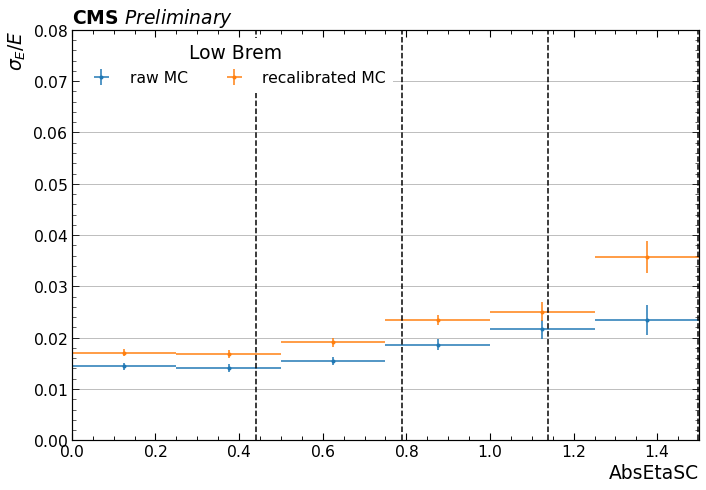

<Figure size 720x504 with 0 Axes>

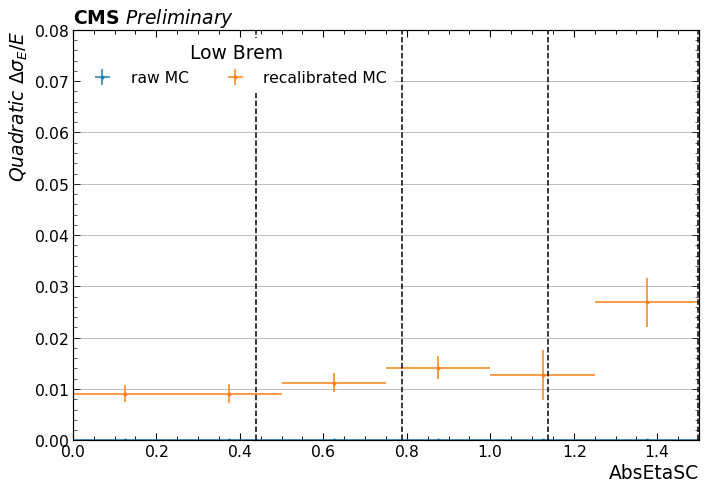

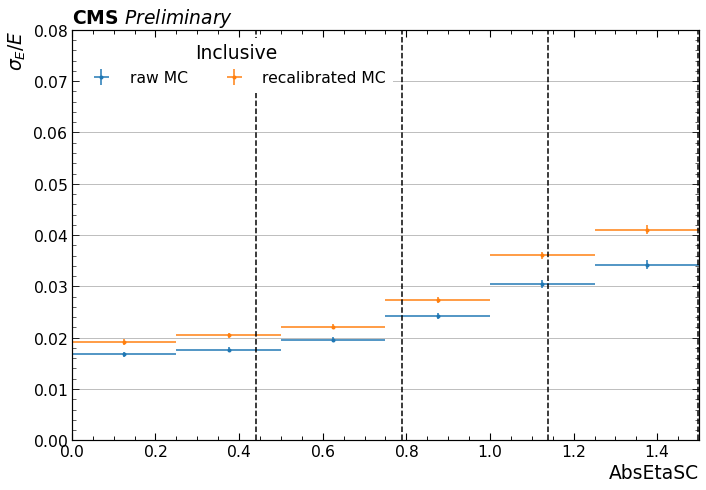

<Figure size 720x504 with 0 Axes>

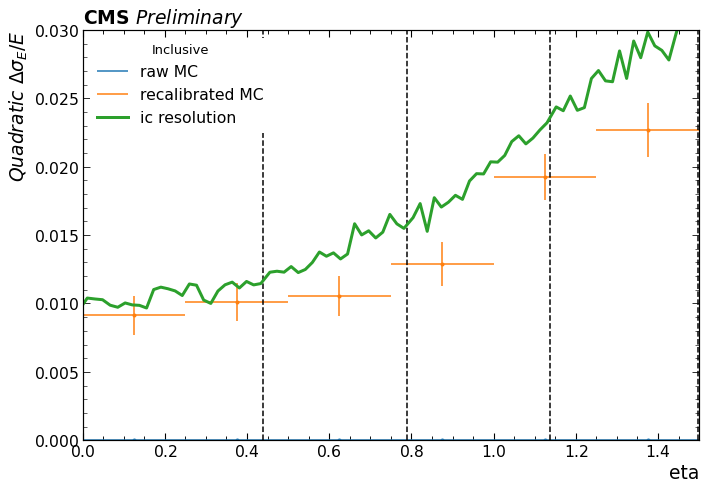

In [46]:
# 3. checkout the measured resolution
ijazz.IJazZEtaPlotter.eta_comparison(cfg, 
            args=DictToOpt(dict(r_name='reso', out=None, x_range=(0, 1.5), y_range=(0, 0.08))))

# the last axis contains the quadratic difference between the 2 measured resolution
# this should correspond to the original smearing added to the MC
reso.plot(ax=plt.gca(), legend='ic resolution', lw=3)
cms_fstyle.polish_axis(plt.gca(), x_range=(0, 1.5), y_range=(0, 0.03))


### Conclusions on the scale and smearing

[YOUR TURN] What do you conclude from these two last plots?
The scale was properly recovered, but one can see that we observed an oversmearing smaller than the one applied at the crystal level, what could be the reason ?